In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Imports and constants

In [2]:
# imports
import scipy.io
import mpmath as mp
import numpy as np
import scipy.linalg as la
from scipy.integrate import quad
from scipy.special import factorial
import matplotlib.pyplot as plt

mp.mp.dps = 50

# physical constants
bohr  = mp.mpf('0.52917706')
redmass = mp.mpf('1')
overmass = mp.mpf('1') / redmass
cfm  = mp.mpf('1822.888515')
auh2mass = mp.mpf('1')/2 * (overmass / cfm)
alpha = mp.mpf('1.0')
ecm = mp.mpf('219474.624')


# Functions

In [3]:
#functions
def hermite_polynomial(n):
  #returns function computing n-th Hermite polynomial
    def H(x):
        return mp.hermite(n, x)
    return H

def phi_n(x, n, alpha):
    Hn = hermite_polynomial(n)
    norm = (alpha/mp.pi)**0.25 / mp.sqrt(2**n * mp.fac(n))
    return norm * mp.exp(-alpha**2 * x**2/2) * Hn(alpha*x)

def integrate_phi_product(i, j, alpha, operator='x'):
    def integrand(x):
        phi_i= phi_n(x, i, alpha)
        phi_j = phi_n(x,j, alpha)
        return phi_i * x *phi_j if operator=='x' else phi_i* phi_j
    val, err = quad(integrand, -mp.inf, mp.inf)
    return val

def construct_matrix(n, alpha, operator):
  # make nxn matrix for given operators
    M = np.zeros((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            M[i,j] = integrate_phi_product(i, j, alpha, operator)
    return M

def kinetic_energy_matrix_raw(n, alpha):
  #KE in FBr basis before basis change (M_DVR = T transpose * M * T)
    K = np.zeros((n, n), dtype=object)
    for i in range(n):
        for j in range(n):
            if i==j:
                K[i,j] = alpha**2 *(i+0.5)
            elif abs(i-j)==2:
                m = max(i,j)
                K[i,j] = -0.5* alpha**2 * mp.sqrt(m*(m-1))
    return K

def transform_matrix(T, M, scale):
  # FBR to DVR transformation
    n = T.shape[0]
    out = np.zeros((n,n), dtype=object)
    for j1 in range(n):
        for j2 in range(n):
            s = mp.mpf('0')
            for i1 in range(n):
                for i2 in range(n):
                    s += T[i1,j1]*M[i1,i2]*T[i2,j2]
            out[j1,j2] = s
    return out

def scale_matrix(M, scale):
    return M * (1/scale)**2

def finalscale(M, factor):
    return M * factor

def print_matrix_dynamically(matrix, description):
    print(f"\n{description}:")
    n = matrix.shape[0]
    for i in range(n):
        print(" ".join(f"{float(matrix[i, j]):14.8f}" for j in range(n)))

# def export_matrix_to_txt(matrix, filepath, label="Matrix"):
#     with open(filepath, 'w') as f:
#         f.write(f"{label}\n")
#         n = matrix.shape[0]
#         for i in range(n):
#             row = " ".join(f"{float(matrix[i, j]):14.8f}" for j in range(n))
#             f.write(row + "\n")
#     print(f"Exported '{label}' to {filepath}")



# Variables to change

nzpt -> num of quadrature points to use

z_min -> position of the first quadrature point

z_max -> the position of the last quadrature point

In [4]:
nzpt = 50

z_min = -1 #left edge (Angstroms)
z_max =  1 #right edge (Angstroms)

# Building and Diagonalizing Position Operators

In [5]:
#raw matrices
K_raw = kinetic_energy_matrix_raw(nzpt, alpha)
Q= construct_matrix(nzpt, alpha, 'x')

**Printing out Position and Raw Kinetic Energy Matrix**

In [26]:
# run to visualize
print_matrix_dynamically(Q, "Original Q Matrix (Position)")
print_matrix_dynamically(K_raw, "Raw Kinetic Energy Matrix in Hermite basis")

In [27]:
# export_matrix_to_txt(Q, "/content/drive/MyDrive/Q_matrix.txt", "Position Operator Matrix (Q)")
# export_matrix_to_txt(K_raw, "/content/drive/MyDrive/K_raw_matrix.txt", "Raw Kinetic Energy (FBR)")

# see data folder to visualize calculated matrices

**Diagonalize**

In [8]:
#Diagonalize Q
eigvals_Q, eigvecs_Q = la.eigh(Q.astype(float))

In [28]:
# Run to visualize Tranformation Matrix
print_matrix_dynamically(eigvecs_Q, "Transformation Matrix T")

# Compute and Scale DVR Grid

In [10]:
z_min_bohr = mp.mpf(z_min) / bohr #[Å/(Å/bohr)] =[Bohr]
z_max_bohr = mp.mpf(z_max) / bohr  #[Bohr]
z_diff_bohr = z_max_bohr - z_min_bohr  #[Bohr]

q_min = eigvals_Q[0]
q_max = eigvals_Q[nzpt-1]
q_diff = q_max - q_min

scalez = z_diff_bohr / q_diff # [Bohr]/[AU]

zqpt = [] #[Å]
for p in eigvals_Q[:nzpt]:
    shifted = p - q_min
    z_bohr = z_min_bohr + shifted * scalez
    z_ang = z_bohr * bohr
    zqpt.append(z_ang)

print("\nScaled DVR Grid Points (zqpt) in Ångströms:")
for i, z in enumerate(zqpt):
    print(f"  Point {i:2d}: {float(z):.11f} Å")


Scaled DVR Grid Points (zqpt) in Ångströms:
  Point  0: -1.00000000000 Å
  Point  1: -0.92816306986 Å
  Point  2: -0.86857644238 Å
  Point  3: -0.81529924169 Å
  Point  4: -0.76606531837 Å
  Point  5: -0.71970758909 Å
  Point  6: -0.67552576874 Å
  Point  7: -0.63305783570 Å
  Point  8: -0.59197834642 Å
  Point  9: -0.55204671368 Å
  Point 10: -0.51307829065 Å
  Point 11: -0.47492701863 Å
  Point 12: -0.43747442160 Å
  Point 13: -0.40062230734 Å
  Point 14: -0.36428774386 Å
  Point 15: -0.32839949082 Å
  Point 16: -0.29289539383 Å
  Point 17: -0.25772043377 Å
  Point 18: -0.22282523286 Å
  Point 19: -0.18816488481 Å
  Point 20: -0.15369801854 Å
  Point 21: -0.11938603178 Å
  Point 22: -0.08519244825 Å
  Point 23: -0.05108236422 Å
  Point 24: -0.01702195814 Å
  Point 25: 0.01702195814 Å
  Point 26: 0.05108236422 Å
  Point 27: 0.08519244825 Å
  Point 28: 0.11938603178 Å
  Point 29: 0.15369801854 Å
  Point 30: 0.18816488481 Å
  Point 31: 0.22282523286 Å
  Point 32: 0.25772043377 Å
  Poin

# Transform & Scale Kinetic Energy to DVR

**RAW FBR to DVR Matrix Transformation**

In [11]:
T = eigvecs_Q #transformation matrix

#Transform + scale kinetic energy to dvr basis
D_K = transform_matrix(T, K_raw, scalez) #T tranpose * K * T

In [31]:
# run to visualize
print_matrix_dynamically(D_K, "Transformed Kinetic Energy Matrix (Unscaled)")

**Scaled Kinetic Energy Matrix to account for coordinate scale**

In [13]:
D_K_scaled = scale_matrix(D_K, scalez)

In [29]:
# run to visualize
print_matrix_dynamically(D_K_scaled, "Transformed Kinetic Energy Matrix (Scaled by 1/scale^2)")

**Final Kinetic Energy Matrix with Mass Scaling**

In [15]:
KE_mat = finalscale(D_K_scaled, auh2mass)

In [30]:
# run to visualize
print_matrix_dynamically(KE_mat, "Final Kinetic Energy Matrix with Mass Scaling")

In [17]:
# export_matrix_to_txt(KE_mat, "/content/drive/MyDrive/KE_matrix.txt", "Final Kinetic Energy (DVR + Mass)")
# see data folder to see matrix visualized

# Define potential for your problem

Example used in paper from Ng, *et al*. :

"Arginine: II. Interactions of Its Salt Bridges with Branched Aliphatic Side Chains"


In [18]:
#fitted quartic coefficients(cm⁻¹)
a0 = mp.mpf('2716')
a1 = mp.mpf('2488')
a2 = mp.mpf('-4.635e4')
a3 = mp.mpf('-2.056e4')
a4 = mp.mpf('2.062e5')

def potential(x):
    """
      V(x) = a0 + a1*x + a2*x^2 + a3*x^3 + a4*x^4

      x -> Angstroms
      returns quartic potential in cm⁻¹

    """
    x = mp.mpf(x)
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

**formation of quadrature points**

In [19]:
#compute potential at each DVR grid point and then normalize to atomic units

potentials = [potential(z) / ecm for z in zqpt] # cm^-1 -> Hartrees

# print out as cm^-1
print("\nQuartic Potential Energies at DVR Points:")
print("  x (Å)       V (cm⁻¹)")
for i, (x, V) in enumerate(zip(zqpt, potentials)):
    print(f"  {float(x):8.4f}    {float(V * ecm):12.6f}")


Quartic Potential Energies at DVR Points:
  x (Å)       V (cm⁻¹)
   -1.0000    180638.000000
   -0.9282    129949.850177
   -0.8686    96420.053424
   -0.8153    72128.441994
   -0.7661    53867.701626
   -0.7197    39905.598842
   -0.6755    29161.549228
   -0.6331    20899.667702
   -0.5920    14588.364177
   -0.5520     9827.110135
   -0.5131     6304.546321
   -0.4749     3772.813959
   -0.4375     2030.967920
   -0.4006      913.796181
   -0.3643      284.021537
   -0.3284       26.708430
   -0.2929       45.158748
   -0.2577      257.844081
   -0.2228      596.079379
   -0.1882     1002.240325
   -0.1537     1428.389104
   -0.1194     1835.214271
   -0.0852     2191.218274
   -0.0511     2472.105577
   -0.0170     2660.338306
    0.0170     2744.836764
    0.0511     2720.810343
    0.0852     2589.711163
    0.1194     2359.308878
    0.1537     2043.891096
    0.1882     1664.600345
    0.2228     1249.926024
    0.2577      836.379272
    0.2929      469.391159
    0.3284    

# Build Total Hamiltonian + Solve for Energy Levels

In [20]:
H_tot = KE_mat + np.diag(potentials)
e_vals, e_vecs = la.eigh(H_tot.astype(float))
first_levels = e_vals[:3] * float(ecm)


print("\nVibrational Energy Levels (relative to ground state):")
print(" Level    Energy (cm⁻¹)     ΔE from Ground (cm⁻¹)")
for i, E in enumerate(e_vals):
    E_cm = float(E) *float(ecm)
    delta_E = E_cm - float(e_vals[0]) * float(ecm)
    print(f"  {i:3d}    {E_cm:14.6f}    {delta_E:18.6f}")


Vibrational Energy Levels (relative to ground state):
 Level    Energy (cm⁻¹)     ΔE from Ground (cm⁻¹)
    0       1178.769149              0.000000
    1       1279.906593            101.137444
    2       2863.042519           1684.273370
    3       3533.197242           2354.428093
    4       4804.285883           3625.516734
    5       6172.693412           4993.924263
    6       7718.475195           6539.706046
    7       9398.721691           8219.952542
    8      11200.065274          10021.296125
    9      13110.443609          11931.674460
   10      15120.634403          13941.865254
   11      17223.120370          16044.351222
   12      19411.644244          18232.875096
   13      21680.896470          20502.127321
   14      24026.303760          22847.534611
   15      26443.878130          25265.108981
   16      28930.105793          27751.336644
   17      31481.863273          30303.094125
   18      34096.352705          32917.583556
   19      36771.0510

# Plot Potential Curve with Energy Levels

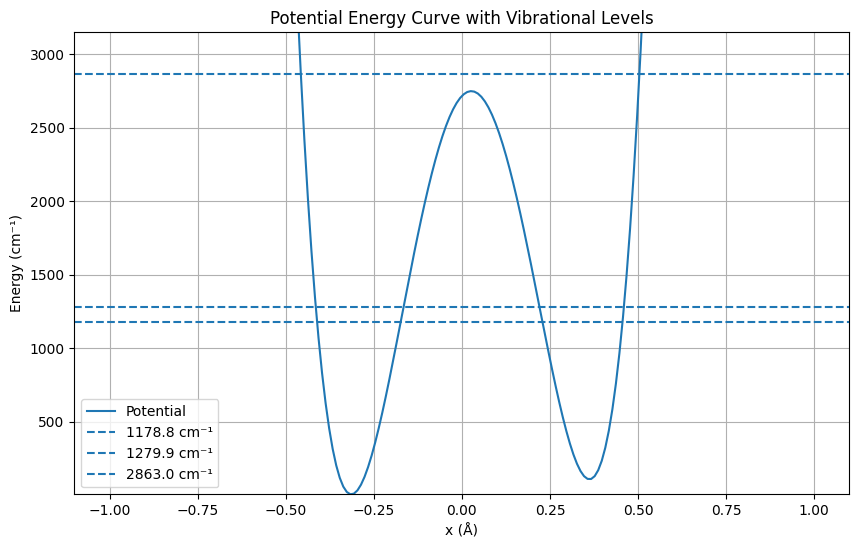

In [21]:
# Plotting:
def plot_potential_graph(x_pts, y_pts, levels):
    plt.figure(figsize=(10,6))
    plt.plot(x_pts, y_pts, label='Potential')
    for lvl in levels:
        plt.axhline(lvl, linestyle='--', label=f'{lvl:.1f} cm⁻¹')
    plt.xlabel('x (Å)')
    plt.ylabel('Energy (cm⁻¹)')
    plt.ylim(min(y_pts), max(levels)*1.1)
    plt.legend()
    plt.grid(True)
    plt.title('Potential Energy Curve with Vibrational Levels')
    plt.show()

x_vals = np.linspace(-1, 1, 200)
y_vals = [float(potential(x)) for x in x_vals]

# Plot potential with energy levels
plot_potential_graph(x_vals, y_vals, first_levels)

# Wavefunctions onto Real-Space Grid

**Variables to input :**


Define your grid placement:

**x_min and x_max** : range of points

**nx**: number of points

**ntotst**: number of states for plotting

In our example, we constructed a 100 point grid from -1 to 1.

In [22]:
# take the eigenvectors of the Hamiltonian in dvr and project onto a realspace grid
# 100 point grid from -1 to 1

xmin, xmax, nx = -1, 1, 100
dx = (xmax-xmin)/nx # [Bohr]

x_grid =[xmin+i*dx for i in range(nx+1)] # [Bohr]
nalpha= nzpt

reciprical_scalez = 1/scalez #[AU/Bohr]

**DVR Basis Function Matrix Construction**

In [23]:
fx = mp.matrix(nalpha, len(x_grid))
for ix, xv in enumerate(x_grid):
    r = xv*reciprical_scalez/bohr
    envelope = mp.sqrt(reciprical_scalez/mp.sqrt(mp.pi))*mp.exp(-r**2/2)
    herms = [mp.hermite(i,r)/mp.sqrt((2**i)*factorial(i)) for i in range(nalpha)]
    for ia in range(nalpha):
        s = mp.mpf('0')
        for j in range(nalpha):
            s += T[j,ia]*herms[j]# FBR -> DVR
        fx[ia,ix] = s*envelope

**Build & Normalize RealSpace Wavefunctions**

In [24]:
ntotst = 3
wfun = mp.matrix(ntotst, len(x_grid))
for st in range(ntotst):
    norm = mp.mpf('0')
    for ix in range(len(x_grid)):
        amp = mp.mpf('0')
        for ia in range(nalpha):
            amp += e_vecs[ia,st]*fx[ia,ix]
        wfun[st,ix] = amp
        norm += amp**2 * dx

    inv = 1/mp.sqrt(norm)
    for ix in range(len(x_grid)):
        wfun[st,ix] *= inv
    print(f'Normalization for state {st}: {sum(wfun[st, ix]**2 * dx for ix in range(len(x_grid)))}')

Normalization for state 0: 1.0
Normalization for state 1: 0.99999999999999999999999999999999999999999999999999
Normalization for state 2: 1.0


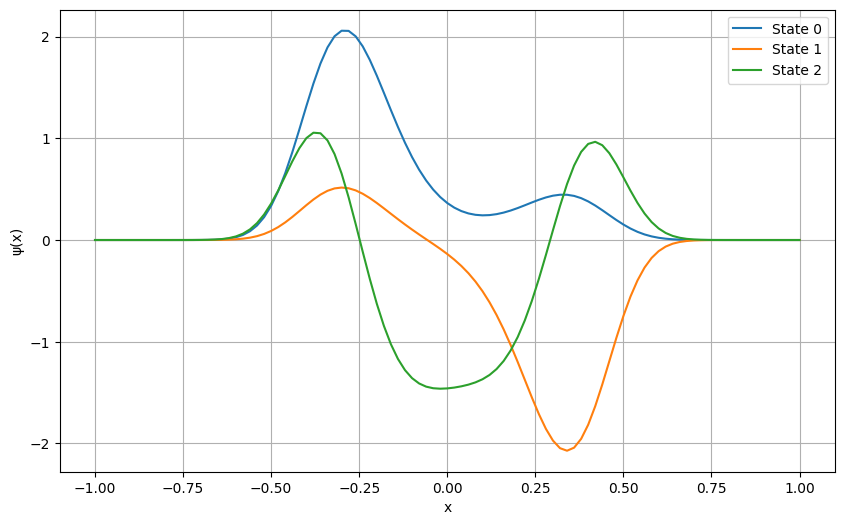

In [25]:
#Plot wavefunctions
plt.figure(figsize=(10,6))
for st in range(ntotst):
    plt.plot(x_grid, [float(wfun[st,ix]) for ix in range(len(x_grid))], label=f'State {st}')
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.legend()
plt.grid(True)
plt.show()